<a href="https://colab.research.google.com/github/PeterYves/DIC-ML-Assignmnent/blob/main/Sprint_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **`[Problem 1] Looking back on scratch`**

---



Look back at the previous scratches so far, To implement deep learning we:

- Had to initialize the weights
- Needed an epoch loop
- Coded the Activation Functions
- Decided the learning rate, sizes, number of nodes and so on

### **`[Problem 2] Consider the correspondence between scratch and TensorFlow`**

---



In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)

df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(int)[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

class GetMiniBatch:

    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):

    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] 
    return layer_output
                               
logits = example_net(X)

loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))

accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Instructions for updating:
non-resource variables are not supported in the long term


Epoch 0, loss : 25.8907, val_loss : 56.8214, acc : 0.750, val_acc : 0.375
Epoch 1, loss : 7.0123, val_loss : 3.6880, acc : 0.250, val_acc : 0.375
Epoch 2, loss : 1.6245, val_loss : 2.9178, acc : 0.500, val_acc : 0.375
Epoch 3, loss : 2.1936, val_loss : 0.9407, acc : 0.750, val_acc : 0.812
Epoch 4, loss : 0.9724, val_loss : 3.8782, acc : 0.750, val_acc : 0.500
Epoch 5, loss : 2.8333, val_loss : 3.8439, acc : 0.750, val_acc : 0.688
Epoch 6, loss : 0.1115, val_loss : 3.4798, acc : 1.000, val_acc : 0.625
Epoch 7, loss : 0.0125, val_loss : 2.5436, acc : 1.000, val_acc : 0.750
Epoch 8, loss : 0.0000, val_loss : 0.3143, acc : 1.000, val_acc : 0.938
Epoch 9, loss : 0.0002, val_loss : 3.1551, acc : 1.000, val_acc : 0.750
test_acc : 0.850


From the above, we see that the Weights initialization is done through tf.Variable(tf.random_normal); Adam is used as an Optimizer and the activation function passes through tf.nn.relu.

### **`[Problem 3] Create a model of Iris using all three types of objective variables`**

---



In [14]:
dataset_path ="Iris.csv"
df = pd.read_csv(dataset_path)

y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(int)[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train)
y_val_one_hot = enc.transform(y_val)
y_test_one_hot = enc.transform(y_test)

class GetMiniBatch:

    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]
    
learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 3

X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

get_mini_batch_train = GetMiniBatch(X_train, y_train_one_hot, batch_size=batch_size)

def example_net(x):
    
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] 
    return layer_output
                             
logits = example_net(X)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1))

accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val_one_hot})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test_one_hot})
    print("test_acc : {:.3f}".format(test_acc))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 0, loss : 18.1945, val_loss : 26.7341, acc : 0.667, val_acc : 0.333
Epoch 1, loss : 0.0169, val_loss : 15.0313, acc : 1.000, val_acc : 0.625
Epoch 2, loss : 0.1760, val_loss : 10.4826, acc : 1.000, val_acc : 0.708
Epoch 3, loss : 0.3062, val_loss : 11.1514, acc : 0.833, val_acc : 0.708
Epoch 4, loss : 0.0000, val_loss : 4.0718, acc : 1.000, val_acc : 0.792
Epoch 5, loss : 0.0000, val_loss : 3.6986, acc : 1.000, val_acc : 0.792
Epoch 6, loss : 0.1857, val_loss : 9.7022, acc : 0.833, val_acc : 0.750
Epoch 7, loss : 0.0000, val_loss : 2.9513, acc : 1.000, val_acc : 0.875
Epoch 8, loss : 0.0000, val_loss : 4.6699, acc : 1.000, val_acc : 0.833
Epoch 9, loss : 0.0000, val_loss : 2.5427, acc : 1.000, val_acc : 0.875
test_acc : 0.967


### **`[Problem 4] Create a model of House Prices`**

---



Epoch 0, loss : 582135.8750, val_loss : 331064.6562
Epoch 1, loss : 32134.8125, val_loss : 22454.8223
Epoch 2, loss : 16662.6309, val_loss : 17108.6152
Epoch 3, loss : 18761.8438, val_loss : 18484.2734
Epoch 4, loss : 66557.9297, val_loss : 63050.5352
Epoch 5, loss : 23824.0410, val_loss : 21752.5352
Epoch 6, loss : 216634.0156, val_loss : 206963.2812
Epoch 7, loss : 146948.9375, val_loss : 141439.6562
Epoch 8, loss : 17615.4473, val_loss : 12584.8926
Epoch 9, loss : 98683.0625, val_loss : 90913.2891
test_mse : 98683.062


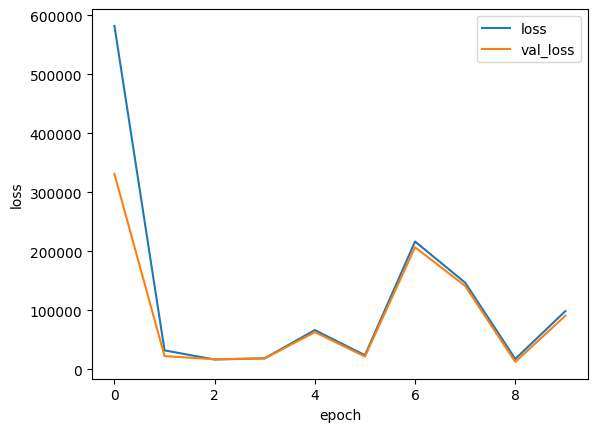

In [15]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

dataset_path ="house_prices.csv"
df = pd.read_csv(dataset_path)

y = df["SalePrice"]
X = df.loc[:, ["GrLivArea", "YearBuilt"]]
y = np.array(y)
X = np.array(X)
y = y.astype(int)[:, np.newaxis]
y = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

class GetMiniBatch:

    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] 
    return layer_output
                               
logits = example_net(X)
loss_op =  tf.losses.mean_squared_error(labels=Y, predictions=logits)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
y_pred = logits

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    loss_list = []
    val_loss_list = []
    for epoch in range(num_epochs):
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
        loss = sess.run(loss_op, feed_dict={X: X_train, Y: y_train})
        loss_list.append(loss)
        val_loss = sess.run(loss_op, feed_dict={X: X_val, Y: y_val})
        val_loss_list.append(val_loss)    
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}".format(epoch, loss, val_loss))
    print("test_mse : {:.3f}".format(loss))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(loss_list, label='loss')
    plt.plot(val_loss_list, label='val_loss')
    plt.legend()
    plt.show()

### **`[Problem 5] Create a model of MNIST`**

---



In [16]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
X_train /= 255
X_test /= 255

y_train = y_train.astype(int)[:, np.newaxis]
y_test = y_test.astype(int)[:, np.newaxis]

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:])
y_test_one_hot = enc.fit_transform(y_test[:])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

class GetMiniBatch:

    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10

X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):

    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] 
    return layer_output
                               
logits = example_net(X)
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)
max_Y = (tf.argmax(Y, 1))
max_Y_pred = tf.argmax(logits, 1)
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
    
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test_one_hot})
    print("test_acc : {:.3f}".format(test_acc))

11490434/11490434 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 0, loss : 2.9346, val_loss : 1.0354, acc : 0.700, val_acc : 0.663
Epoch 1, loss : 0.9302, val_loss : 0.9286, acc : 0.700, val_acc : 0.758
Epoch 2, loss : 1.2839, val_loss : 0.7351, acc : 0.700, val_acc : 0.783
Epoch 3, loss : 1.0496, val_loss : 0.4540, acc : 0.600, val_acc : 0.885
Epoch 4, loss : 1.1441, val_loss : 0.4164, acc : 0.700, val_acc : 0.897
Epoch 5, loss : 0.9176, val_loss : 0.3852, acc : 0.700, val_acc : 0.913
Epoch 6, loss : 1.2794, val_loss : 0.3699, acc : 0.600, val_acc : 0.909
Epoch 7, loss : 0.8638, val_loss : 0.4308, acc : 0.800, val_acc : 0.915
Epoch 8, loss : 0.6559, val_loss : 0.3647, acc : 0.800, val_acc : 0.922
Epoch 9, loss : 1.0141, val_loss : 0.3691, acc : 0.600, val_acc : 0.918
test_acc : 0.920
